# Genomic Scan Plots

In [13]:
library(data.table)
library(tidyverse)
library(foreach)
library(gridExtra)
setwd('~/snap_hap_repHZ/genome_scans/')
plot_theme <- theme_bw() + theme(panel.grid = element_blank())

## Functions

In [3]:
modify_for_ManhattanPlot = function(dat){
    dat %>% 
        # Compute chromosome size
        group_by(scaffold) %>% summarise(chromLength = max(end)) %>% 
    
        # Calculate cumulative position of each chromosome
        mutate(total = cumsum(chromLength)-chromLength) %>% select(-chromLength) %>%
    
        # Add this info to the initial dataset
        left_join(dat, ., by=c("scaffold"="scaffold")) %>%
    
        # Add a cumulative position of each SNP
        arrange(scaffold, end) %>%
        mutate(midCum = mid+total)
}

In [4]:
axis_for_ManhattanPlot = function(modified_dat, col1, col2){
    modified_dat %>%
        group_by(scaffold) %>% summarize(chromCenter = (max(midCum, na.rm=T) + min(midCum, na.rm=T))/2) %>%
        mutate(col = rep(c(col1, col2), 4))
}

## Read files & modify

In [5]:
AvePla_w10KBs10KB = foreach(chrom=c(1:8), .combine=rbind) %do% {
    file=paste0('./AvePla/Ave-Pla_Chr',chrom,'_byPos_w10000_s10000.csv.gz')
    dat = fread(file)
    return(dat)
}

AvePlaFRYe_w10KBs10KB = foreach(chrom=c(1:8), .combine=rbind) %do% {
    file=paste0('./AvePla-FRYe/AveFR-AveY-PlaFR-PlaY_Chr',chrom,'_byPos_w10000_s10000.csv.gz')
    dat = fread(file)
    return(dat)
}

In [6]:
AvePla_w10KBs10KB = modify_for_ManhattanPlot(AvePla_w10KBs10KB)
AvePlaFRYe_w10KBs10KB = modify_for_ManhattanPlot(AvePlaFRYe_w10KBs10KB)

In [7]:
axisToPlot = axis_for_ManhattanPlot(AvePlaFRYe_w10KBs10KB, 'grey10','grey80')

In [7]:
str(AvePla_w10KBs10KB)

Classes ‘data.table’ and 'data.frame':	50881 obs. of  12 variables:
 $ windowID   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ scaffold   : chr  "Chr1" "Chr1" "Chr1" "Chr1" ...
 $ start      : int  1 10001 20001 30001 40001 50001 60001 70001 80001 90001 ...
 $ end        : int  10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 ...
 $ mid        : num  7311 15387 24812 31845 NaN ...
 $ sites      : int  118 126 227 53 0 20 209 199 219 152 ...
 $ pi_Ave     : num  0.305 0.234 0.229 0.271 NaN ...
 $ pi_Pla     : num  0.283 0.219 0.237 0.21 NaN ...
 $ dxy_Ave_Pla: num  0.297 0.236 0.241 0.249 NaN ...
 $ Fst_Ave_Pla: num  0.0055 0.0202 0.0167 0.0177 NaN 0.0289 0.0523 0.0586 0.038 0.0213 ...
 $ total      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ midCum     : num  7311 15387 24812 31845 NaN ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [8]:
str(AvePlaFRYe_w10KBs10KB)

Classes ‘data.table’ and 'data.frame':	50881 obs. of  24 variables:
 $ windowID       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ scaffold       : chr  "Chr1" "Chr1" "Chr1" "Chr1" ...
 $ start          : int  1 10001 20001 30001 40001 50001 60001 70001 80001 90001 ...
 $ end            : int  10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 ...
 $ mid            : num  7311 15387 24812 31845 NaN ...
 $ sites          : int  118 126 227 53 0 20 209 199 219 152 ...
 $ pi_AveFR       : num  0.278 0.233 0.228 0.257 NaN ...
 $ pi_AveY        : num  0.324 0.23 0.221 0.278 NaN ...
 $ pi_PlaFR       : num  0.287 0.202 0.22 0.225 NaN ...
 $ pi_PlaY        : num  0.28 0.234 0.252 0.192 NaN ...
 $ dxy_AveFR_AveY : num  0.309 0.236 0.234 0.274 NaN ...
 $ dxy_AveFR_PlaFR: num  0.281 0.224 0.227 0.244 NaN ...
 $ dxy_AveFR_PlaY : num  0.281 0.238 0.247 0.242 NaN ...
 $ dxy_AveY_PlaFR : num  0.313 0.233 0.232 0.259 NaN ...
 $ dxy_AveY_PlaY  : num  0.315 0.248 0.257 0.252 NaN ...
 $ dxy_PlaFR_PlaY :

In [9]:
# str(axisToPlot)
print(axisToPlot)

# A tibble: 8 × 3
  scaffold chromCenter col   
  <chr>          <dbl> <chr> 
1 Chr1       35959973  grey10
2 Chr2      110481039  grey80
3 Chr3      181659543  grey10
4 Chr4      241702345  grey80
5 Chr5      304644325  grey10
6 Chr6      367995190. grey80
7 Chr7      423619885  grey10
8 Chr8      480104466. grey80


## Plots

### Fst

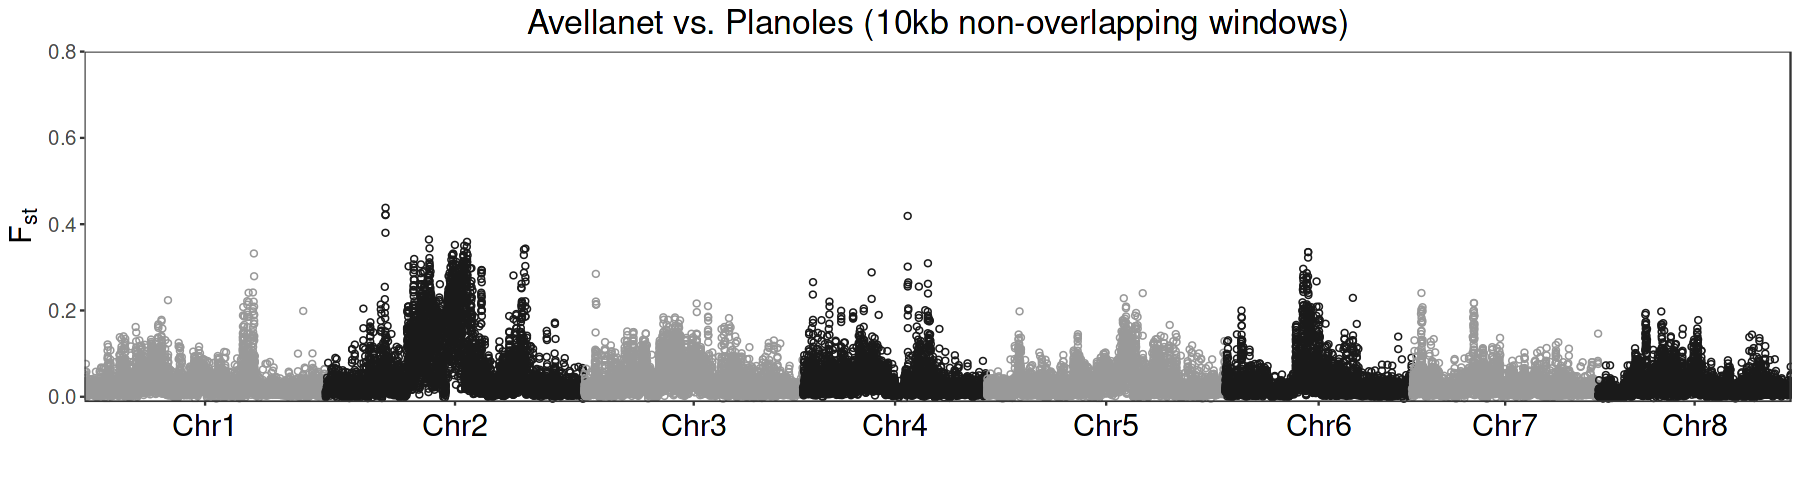

In [10]:
options(repr.plot.width=15, repr.plot.height=4)

fst_Ave_Pla = ggplot(AvePla_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_Ave_Pla)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.8)) +
    labs(x='', y=expression(F[st]), title='Avellanet vs. Planoles (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_Ave_Pla

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


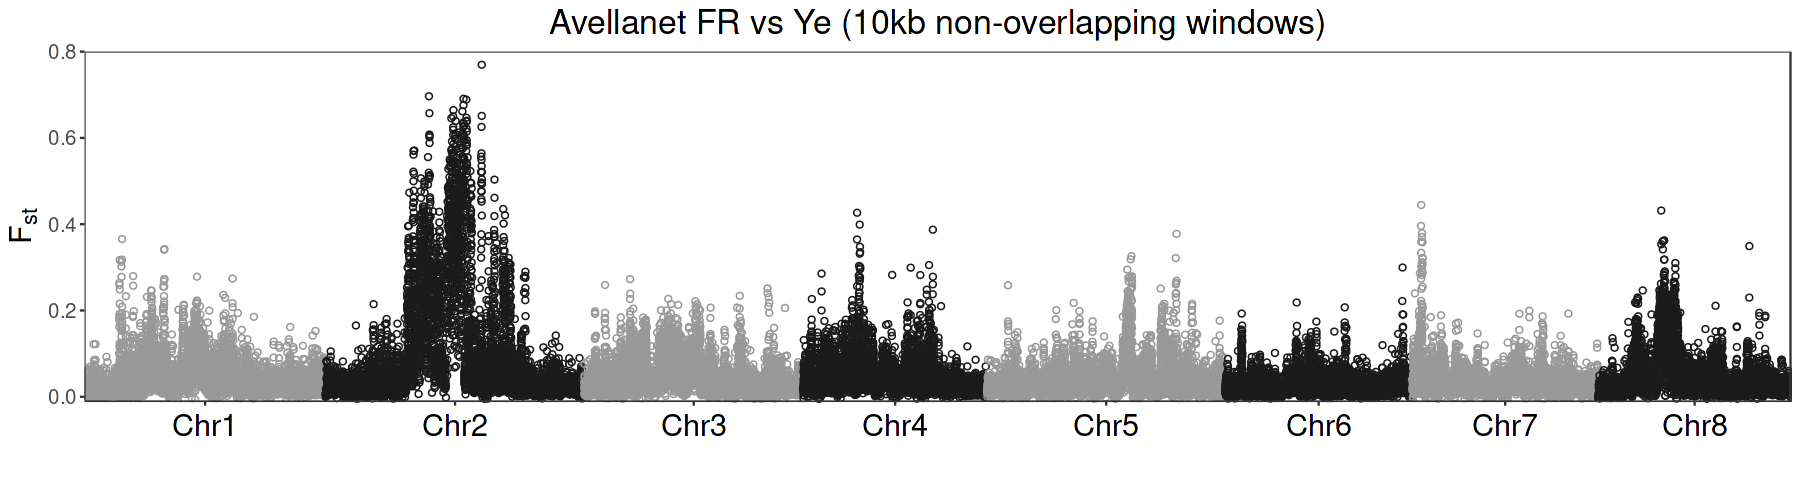

In [11]:
options(repr.plot.width=15, repr.plot.height=4)

fst_AveFR_AveY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_AveFR_AveY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.8)) +
    labs(x='', y=expression(F[st]), title='Avellanet FR vs Ye (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_AveFR_AveY

Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`).”


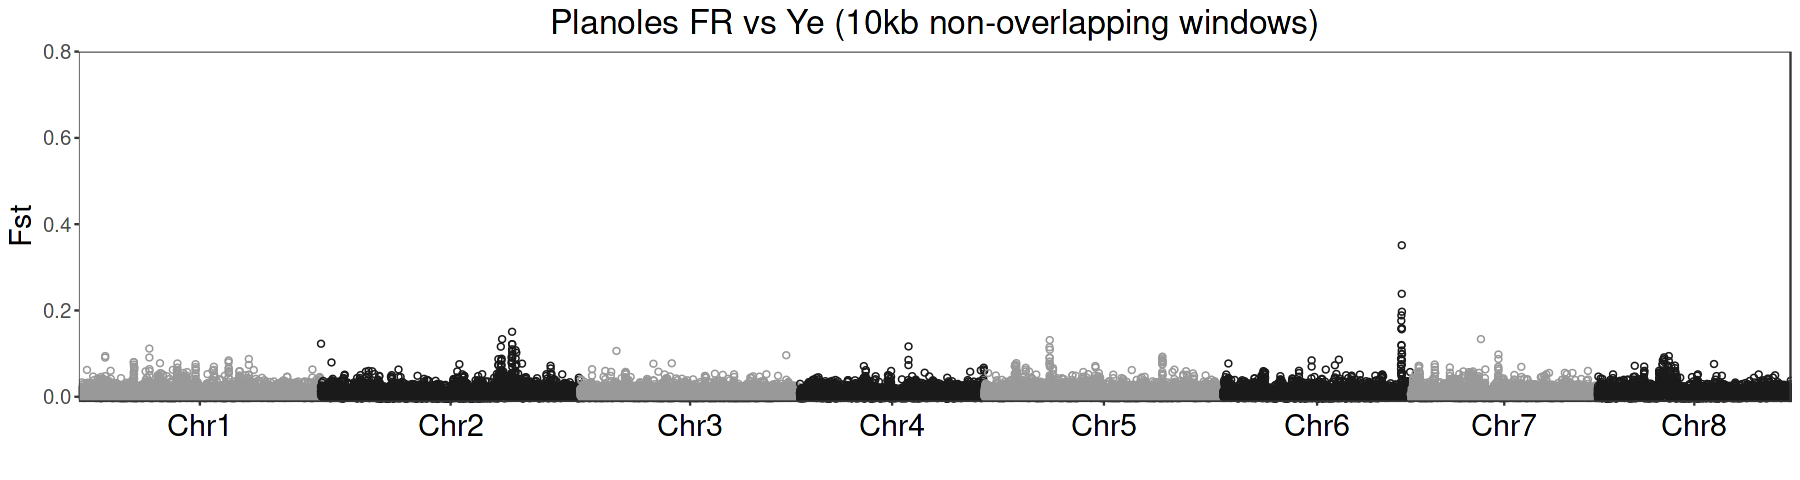

In [12]:
options(repr.plot.width=15, repr.plot.height=4)

fst_PlaFR_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_PlaFR_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.8)) +
    labs(x='', y='Fst', title='Planoles FR vs Ye (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_PlaFR_PlaY

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


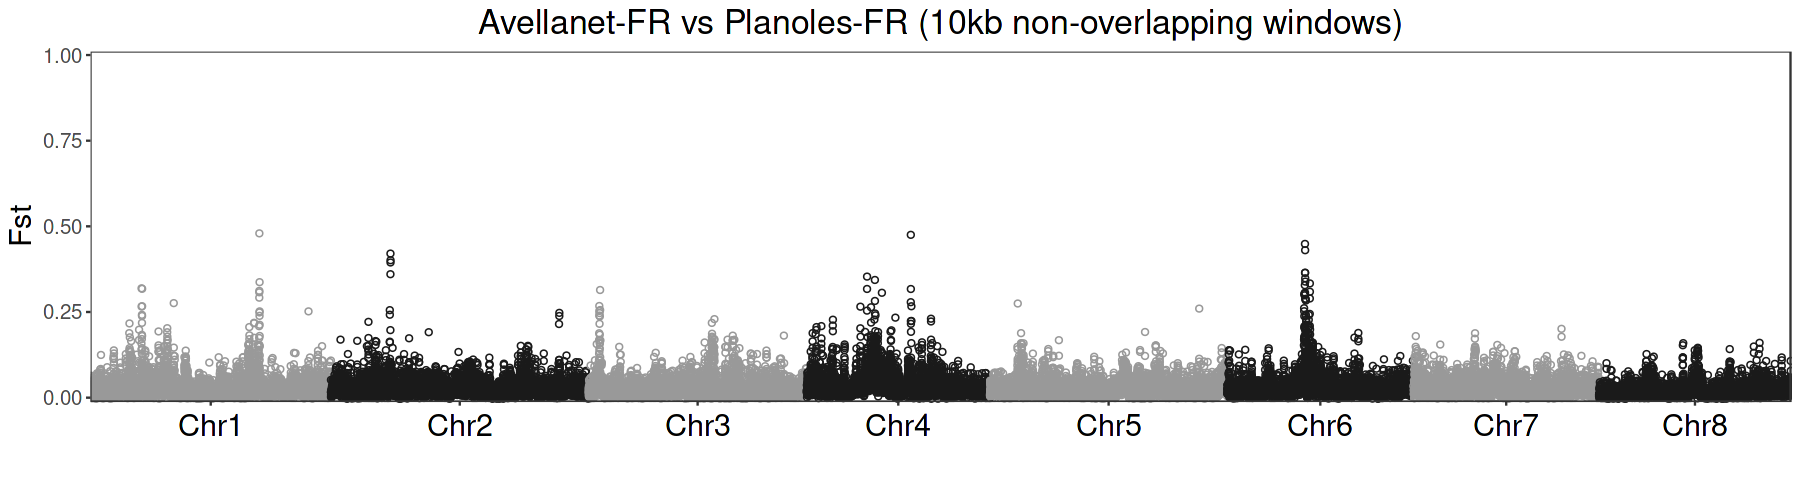

In [13]:
options(repr.plot.width=15, repr.plot.height=4)

fst_AveFR_PlaFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_AveFR_PlaFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1.01)) +
    labs(x='', y='Fst', title='Avellanet-FR vs Planoles-FR (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_AveFR_PlaFR

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


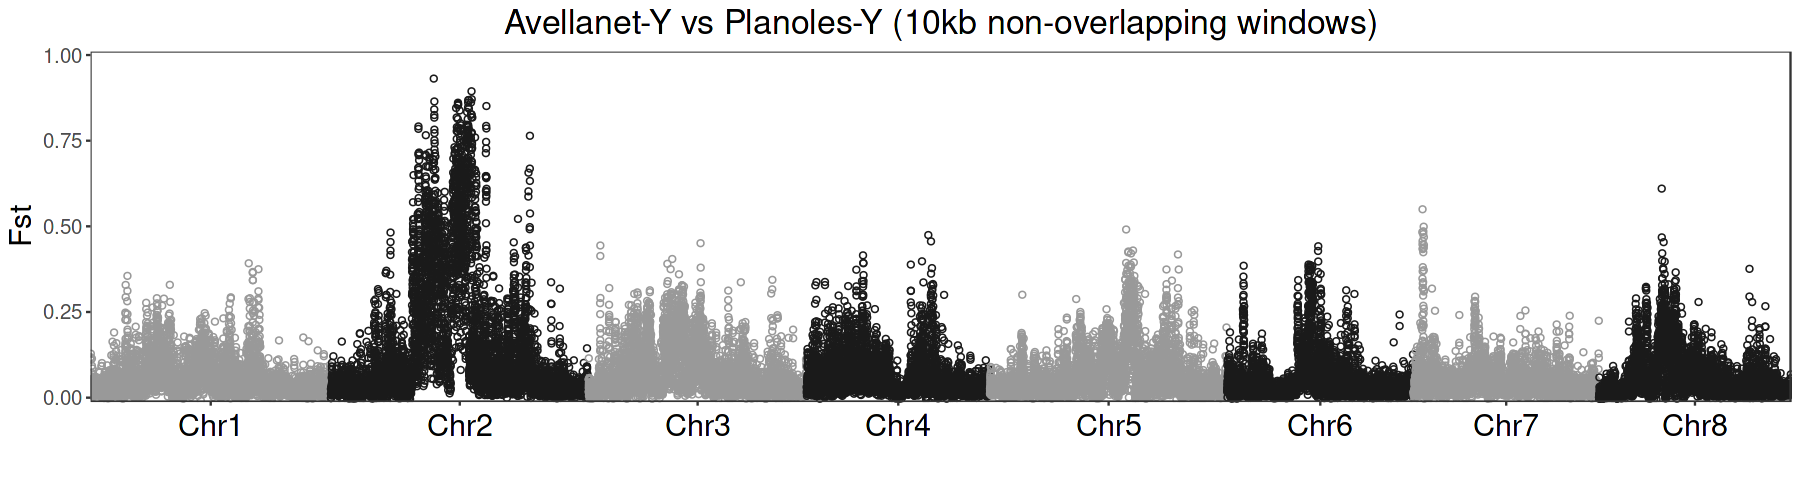

In [14]:
options(repr.plot.width=15, repr.plot.height=4)

fst_AveY_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_AveY_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1.01)) +
    labs(x='', y='Fst', title='Avellanet-Y vs Planoles-Y (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_AveY_PlaY

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


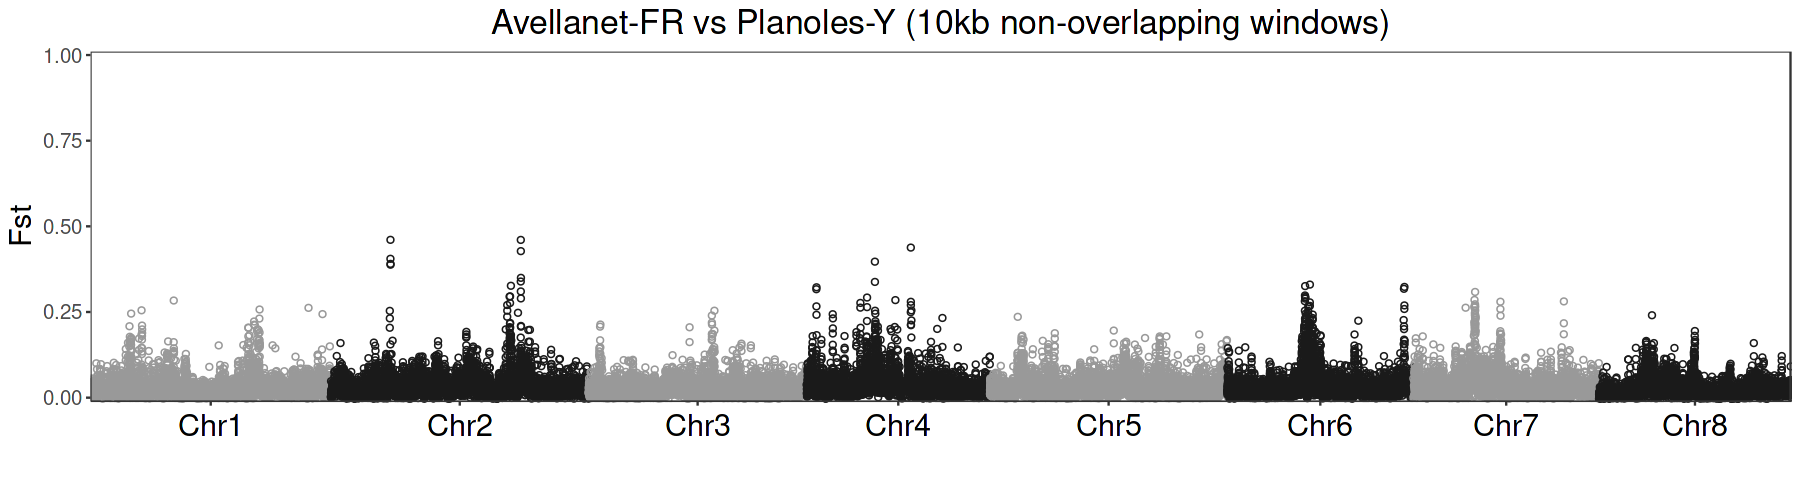

In [60]:
options(repr.plot.width=15, repr.plot.height=4)

fst_AveFR_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_AveFR_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1.01)) +
    labs(x='', y='Fst', title='Avellanet-FR vs Planoles-Y (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_AveFR_PlaY

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


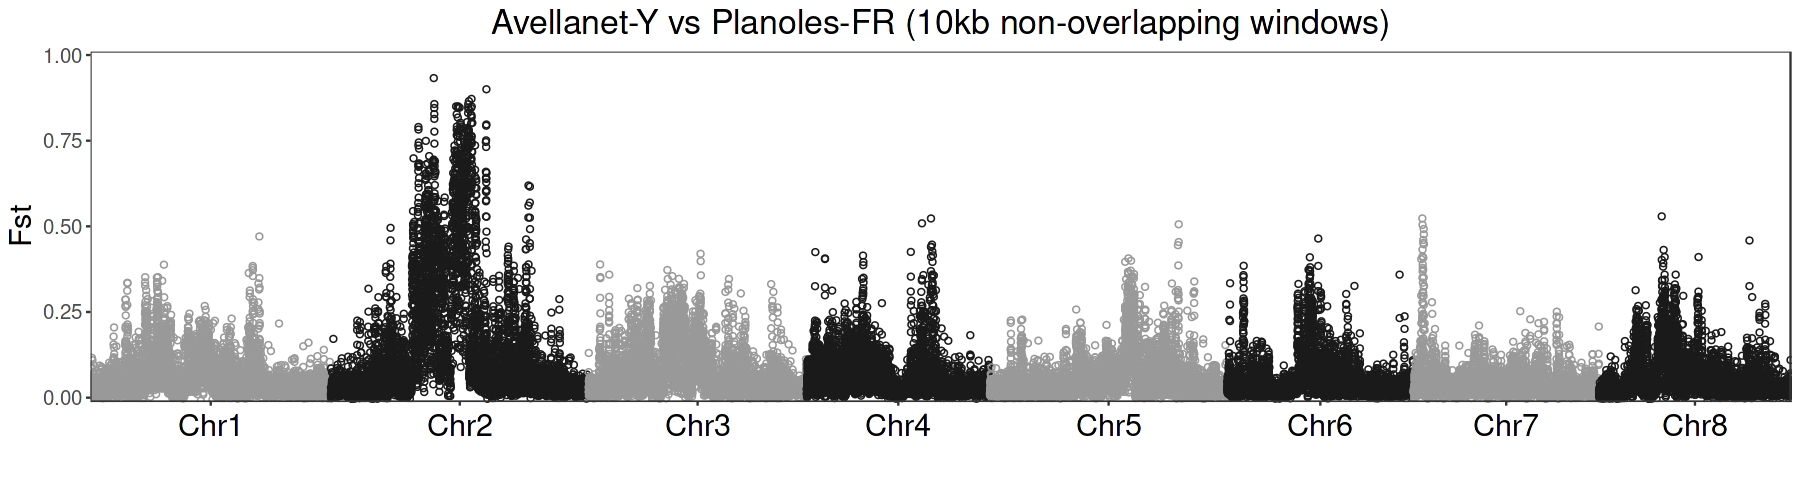

In [61]:
options(repr.plot.width=15, repr.plot.height=4)

fst_AveY_PlaFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=Fst_AveY_PlaFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=1, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1.01)) +
    labs(x='', y='Fst', title='Avellanet-Y vs Planoles-FR (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )
fst_AveY_PlaFR

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`).”


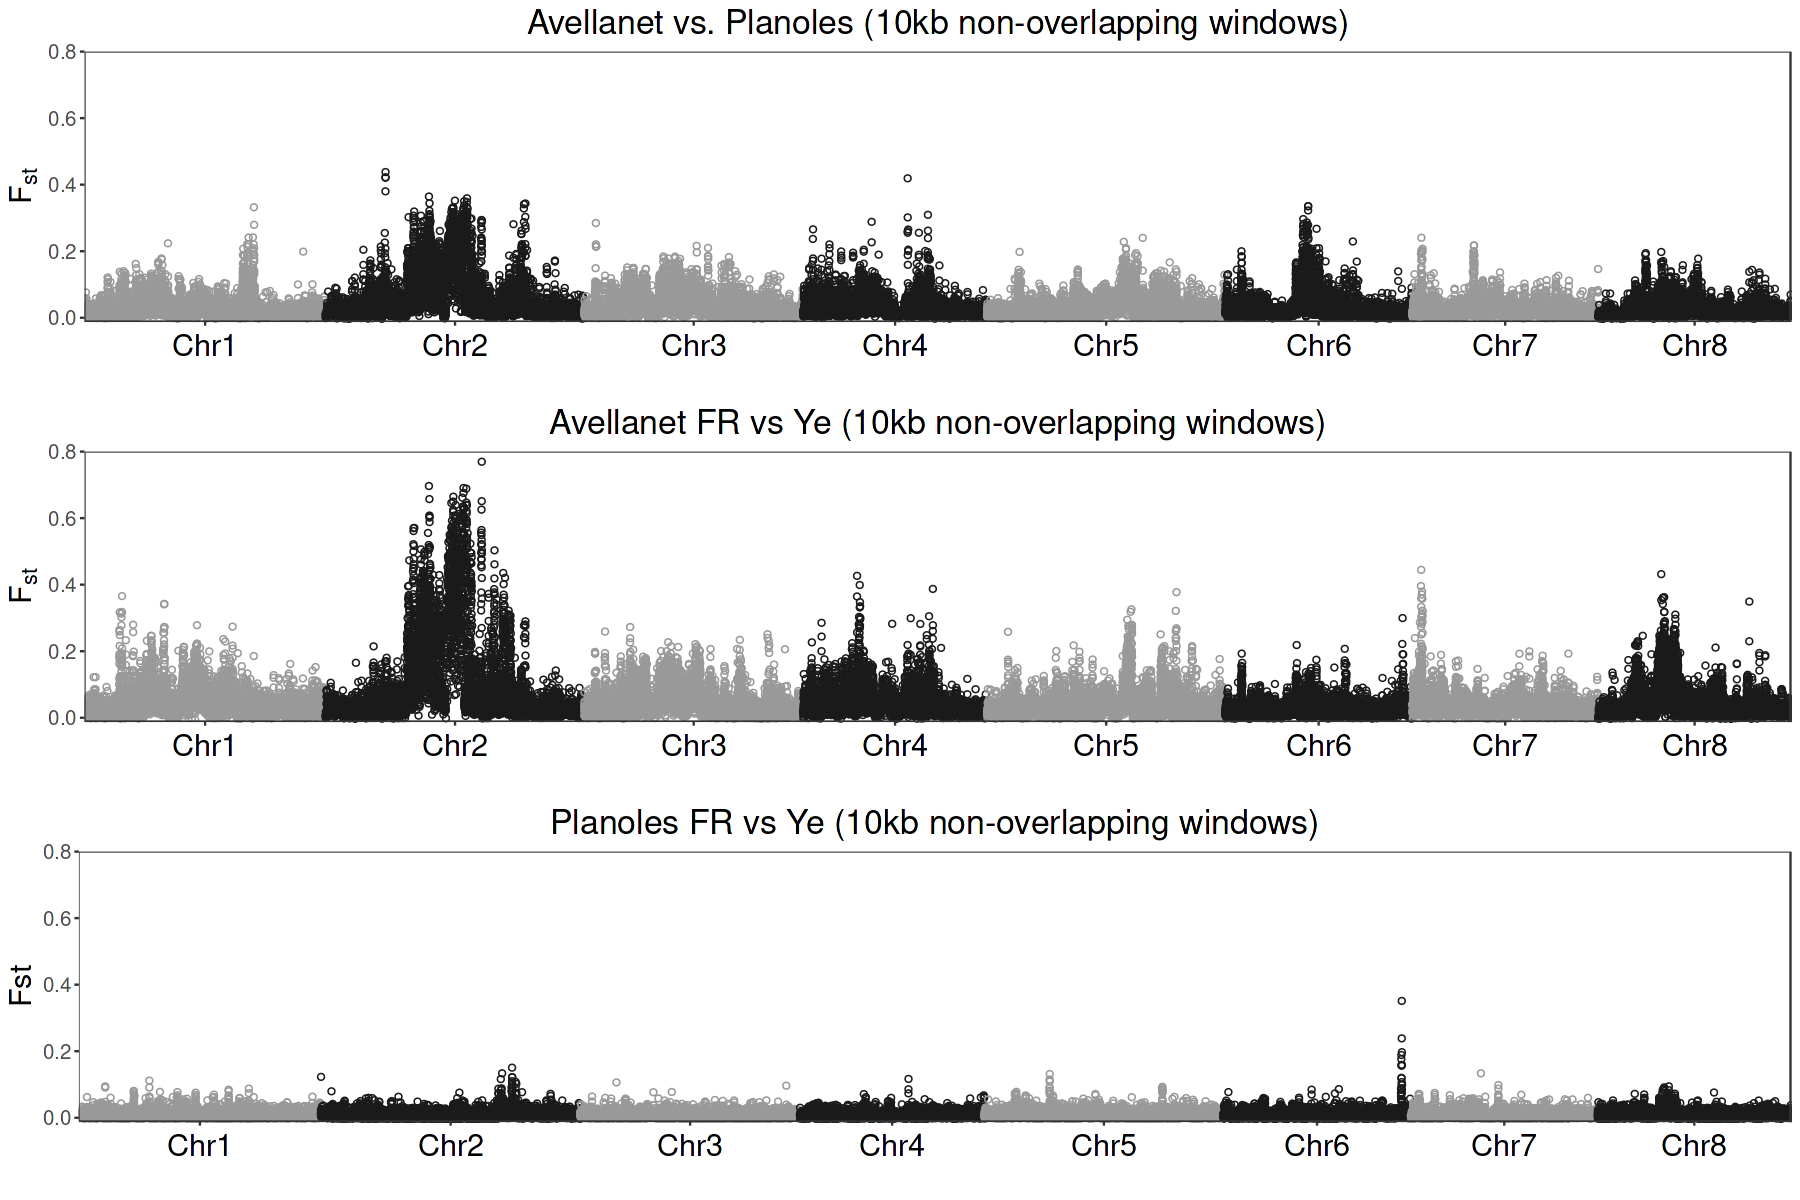

In [15]:
options(repr.plot.width=15,repr.plot.height=10)
grid.arrange(fst_Ave_Pla, fst_AveFR_AveY, fst_PlaFR_PlaY, nrow=3)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


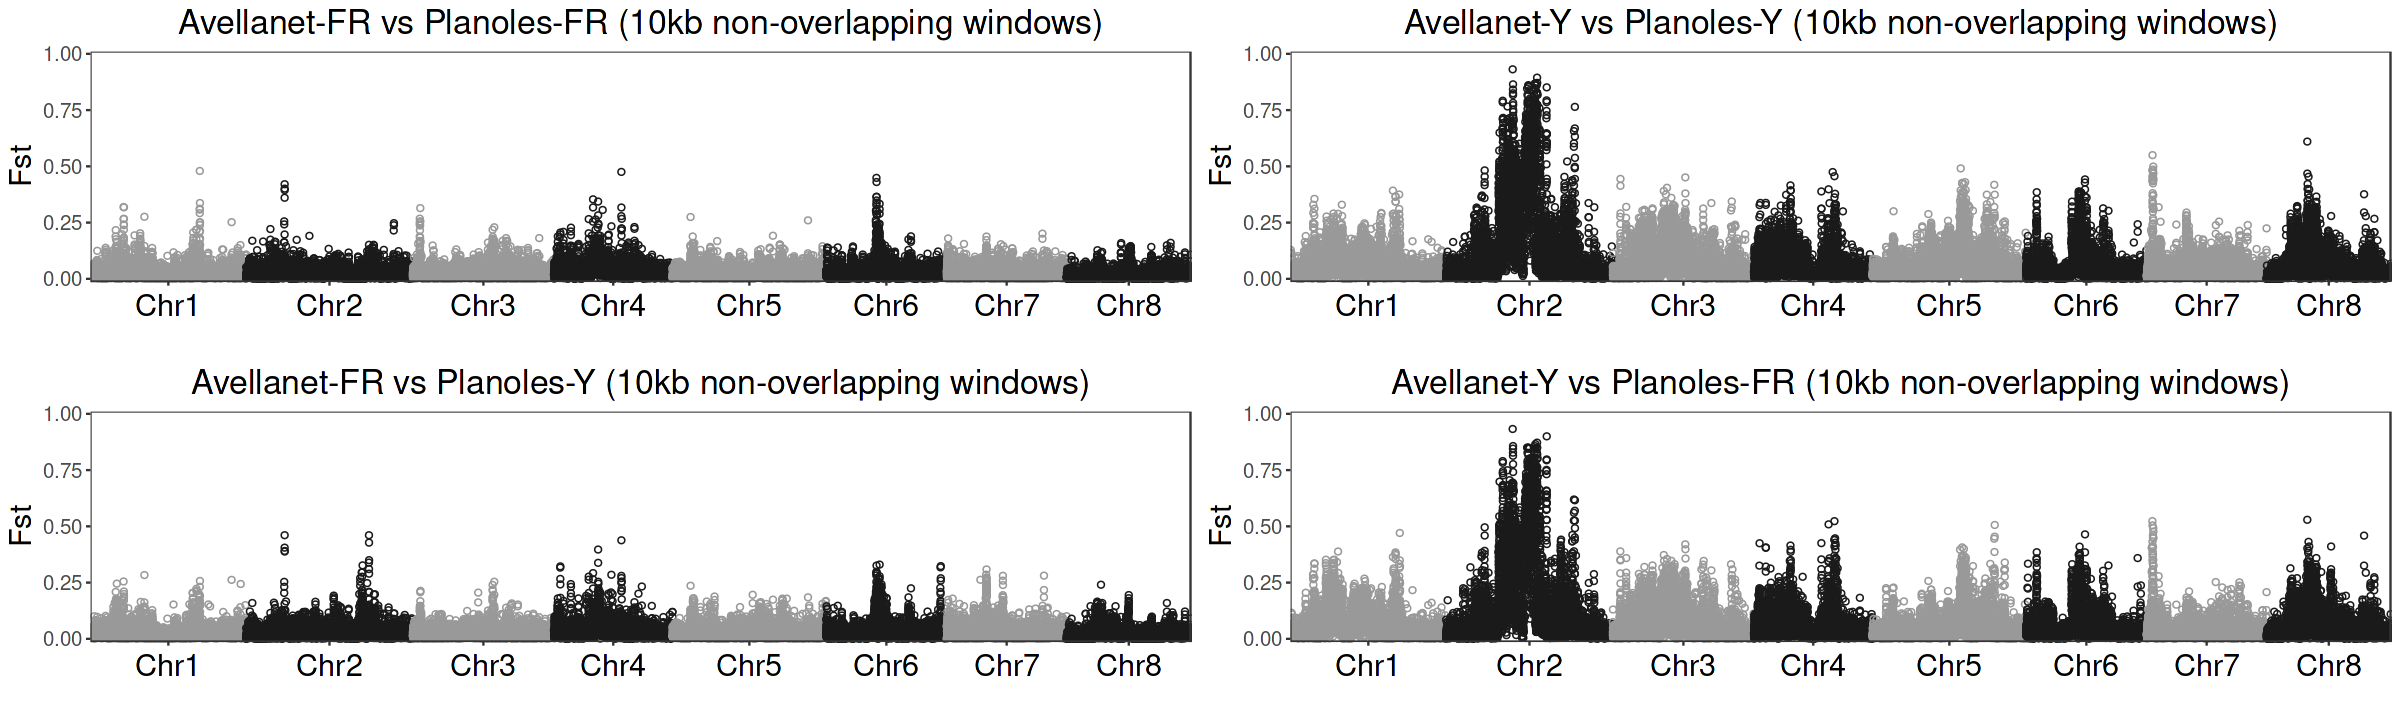

In [64]:
options(repr.plot.width=20,repr.plot.height=6)
grid.arrange(fst_AveFR_PlaFR, fst_AveY_PlaY, 
             fst_AveFR_PlaY, fst_AveY_PlaFR,
             nrow=2)

### Fst in Rosel

Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 5149 rows containing missing values or values outside the scale range
(`geom_line()`).”


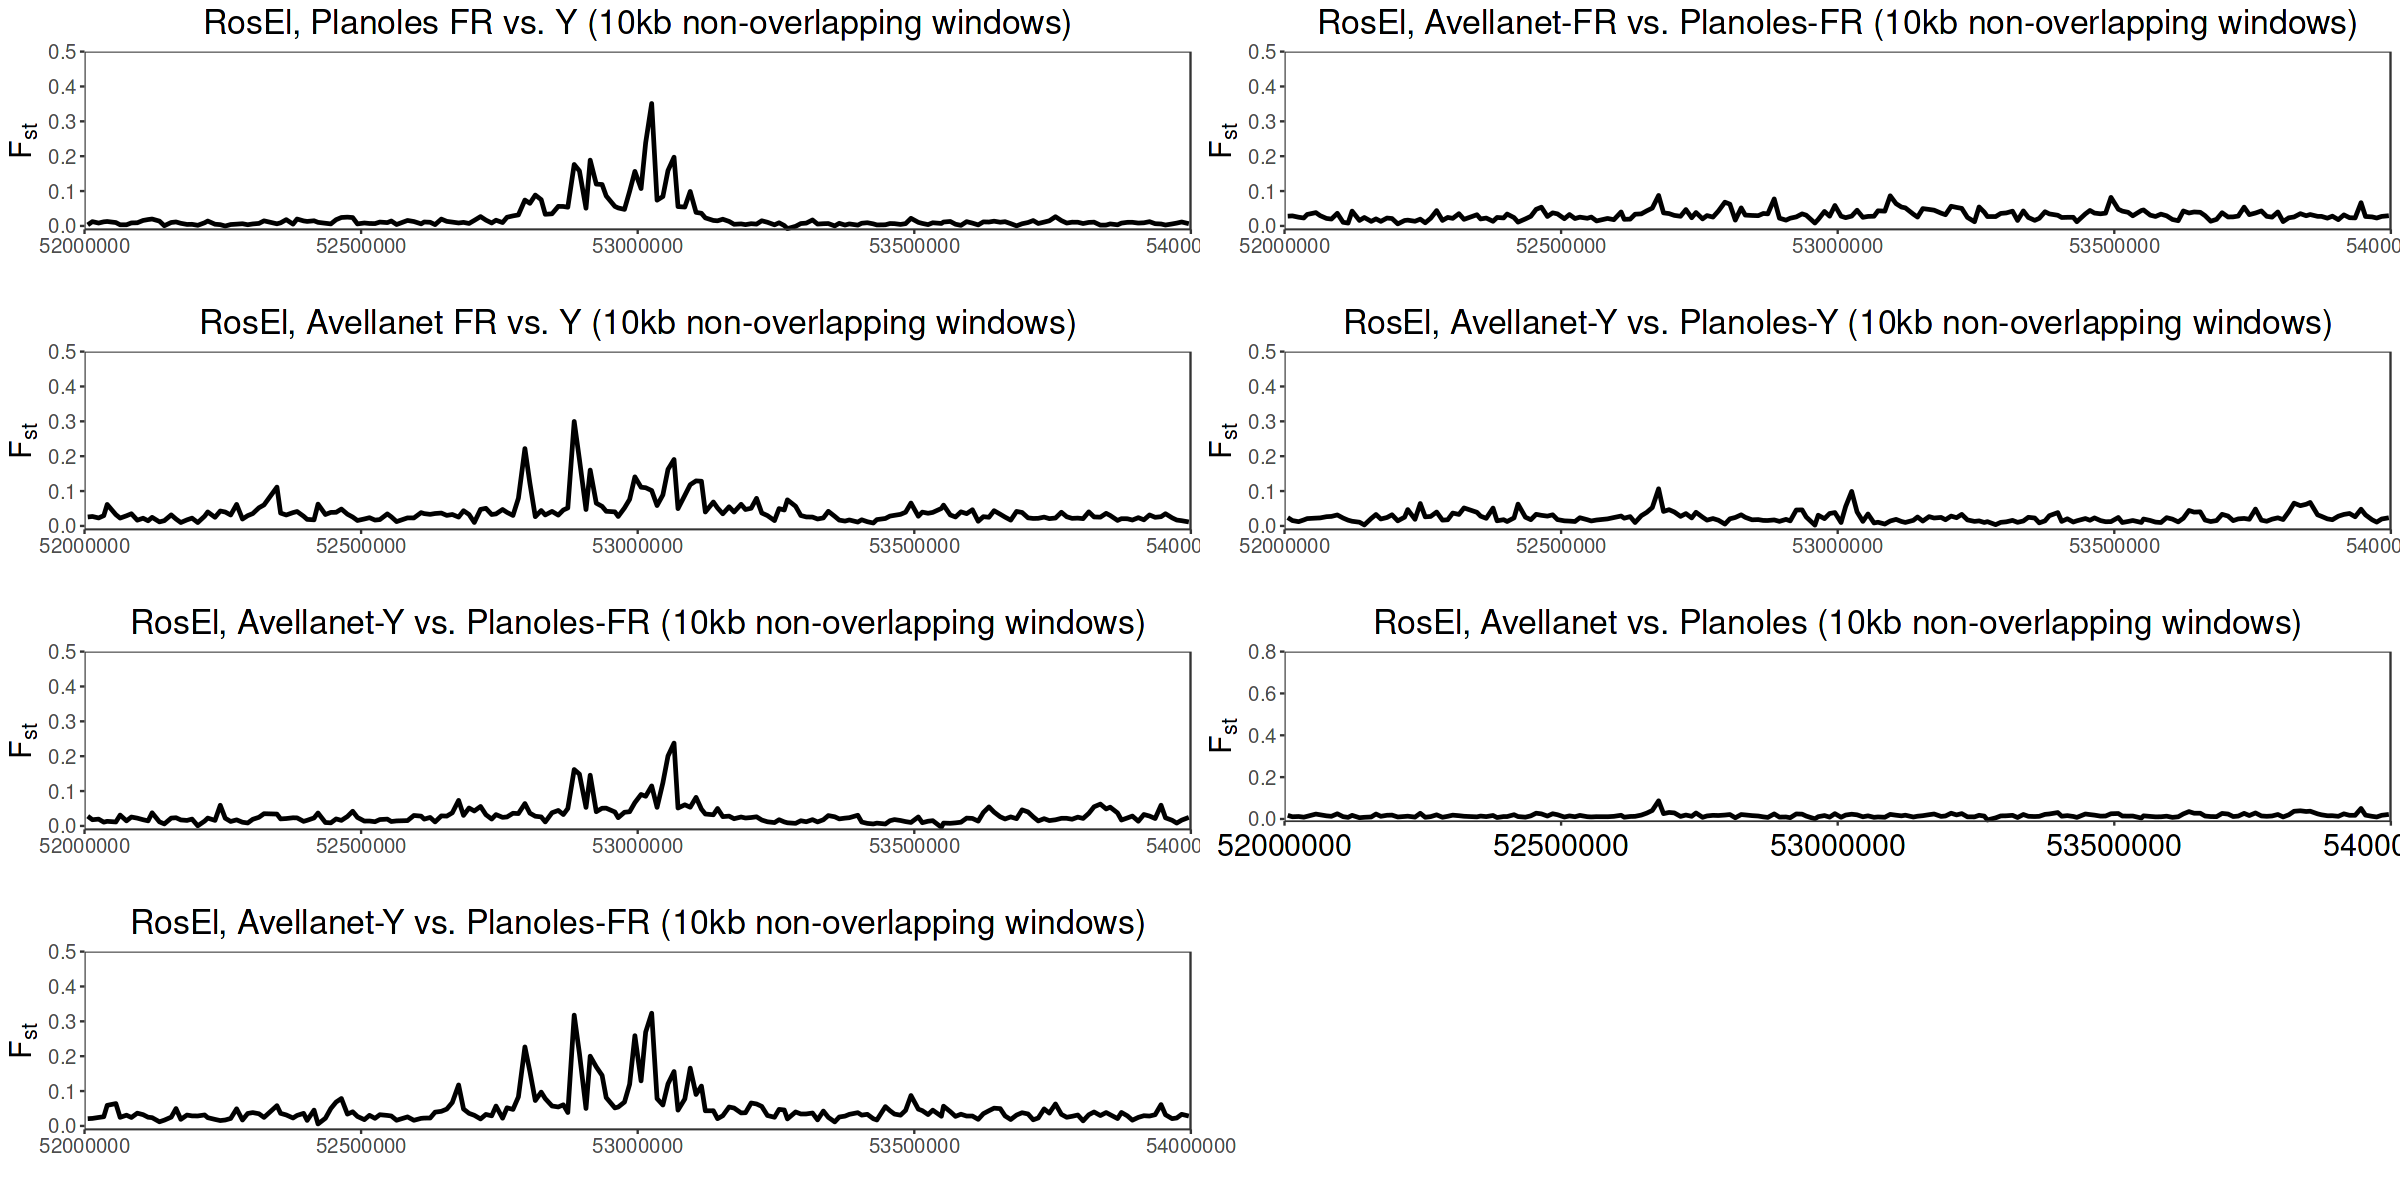

In [59]:
RosEl=c(52000000,54000000)

fst_Ave_Pla_rosel = ggplot(AvePla_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_Ave_Pla)) +
    geom_line(alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.8)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet vs. Planoles (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
          )

fst_PlaFR_PlaY_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_PlaFR_PlaY)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Planoles FR vs. Y (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

fst_AveFR_AveY_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_AveFR_AveY)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet FR vs. Y (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

fst_AveFR_PlaFR_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_AveFR_PlaFR)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet-FR vs. Planoles-FR (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

fst_AveY_PlaY_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_AveY_PlaY)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet-Y vs. Planoles-Y (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

fst_AveY_PlaFR_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_AveY_PlaFR)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet-Y vs. Planoles-FR (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

fst_AveFR_PlaY_rosel = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10 & scaffold == 'Chr6'], aes(x=mid, y=Fst_AveFR_PlaY)) +
    geom_line(aes(color=as.factor(scaffold)), alpha=1, lwd=1, col='black') +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    
    # Axes and labels:
    scale_x_continuous(expand = c(0, 0), limits=RosEl) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,0.5)) +
    labs(x='', y=expression(F[st]), title='RosEl, Avellanet-Y vs. Planoles-FR (10kb non-overlapping windows)') +
    
    # Customize the theme:
    plot_theme + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size=20), 
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 12)
          )

options(repr.plot.width=20, repr.plot.height=10)
grid.arrange(fst_PlaFR_PlaY_rosel,
             fst_AveFR_PlaFR_rosel,
             fst_AveFR_AveY_rosel,
             fst_AveY_PlaY_rosel,
             fst_AveY_PlaFR_rosel,
             fst_Ave_Pla_rosel,
             fst_AveFR_PlaY_rosel, nrow=4)

### Dxy, pi

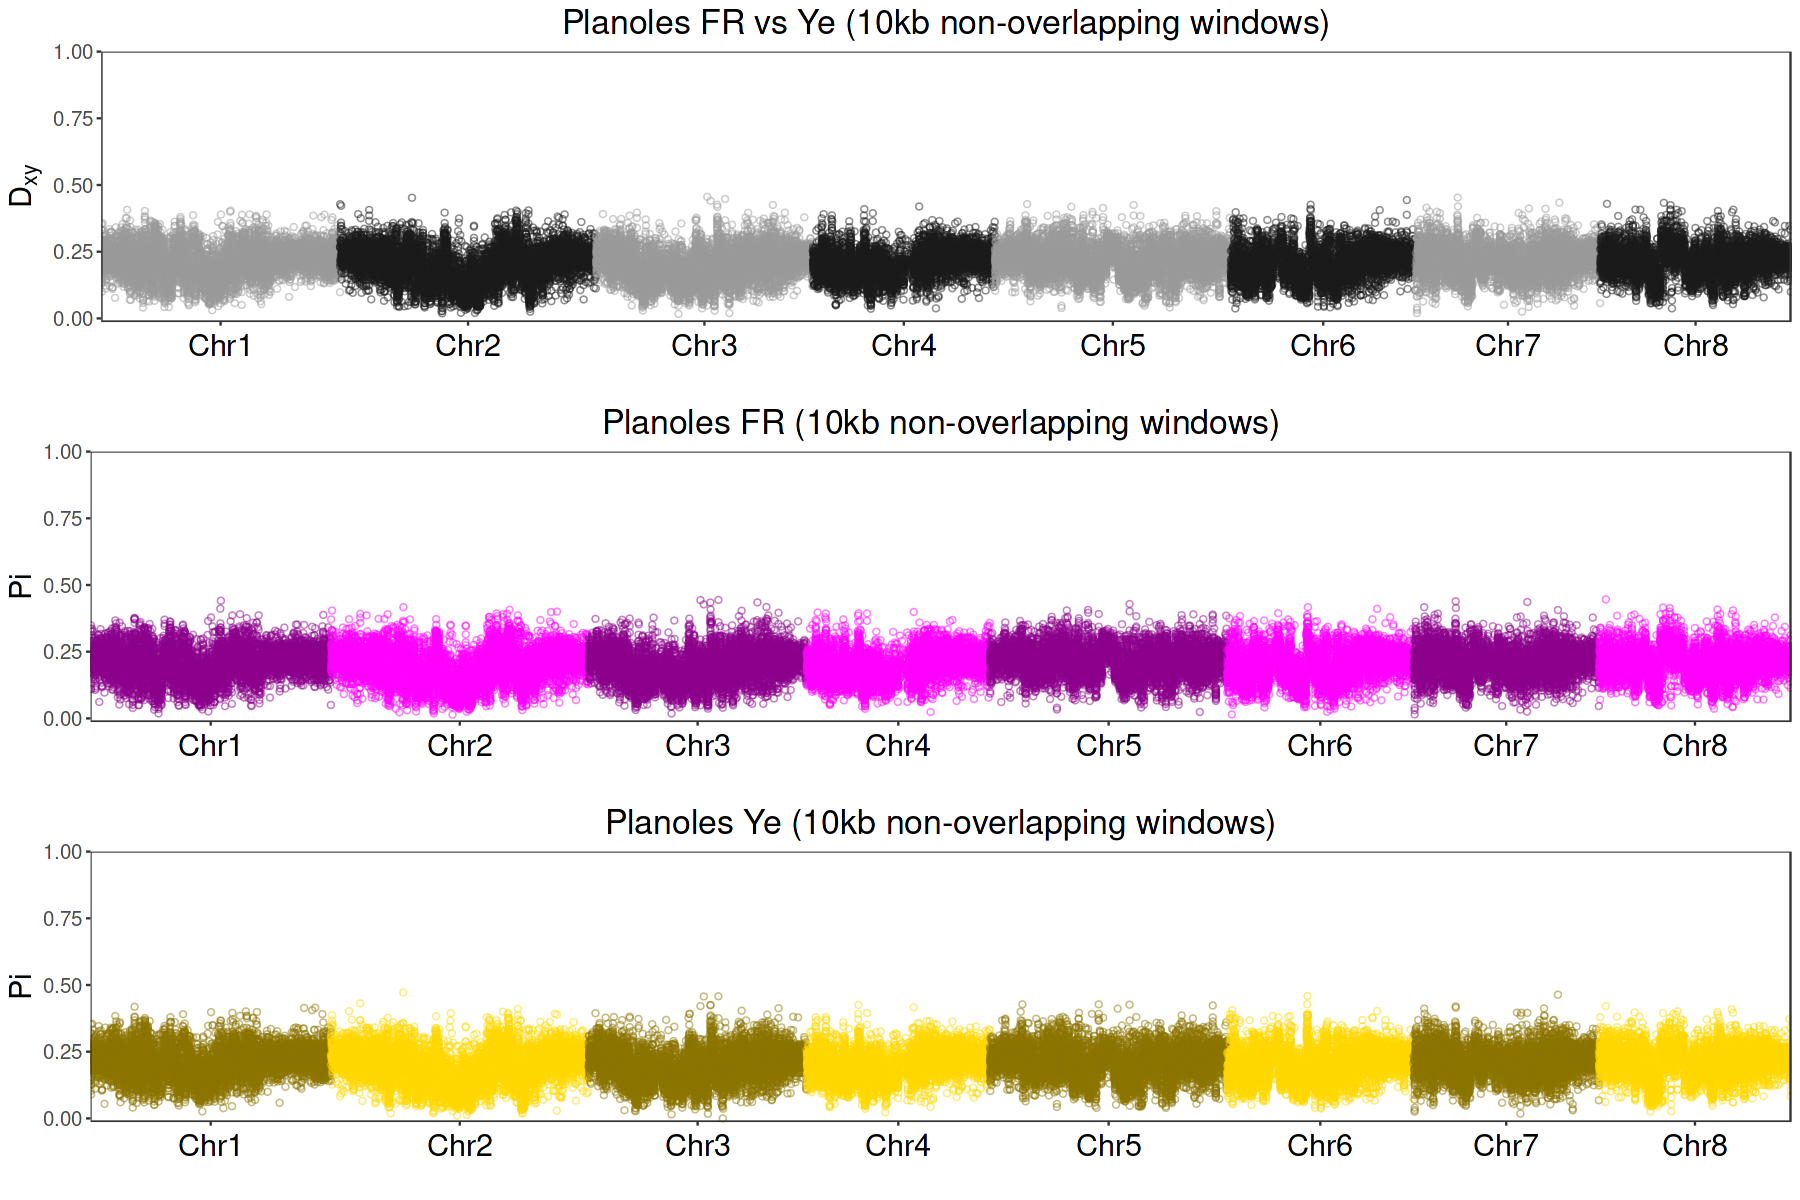

In [18]:
options(repr.plot.width=15, repr.plot.height=10)
plot_theme1 = plot_theme + 
                theme(legend.position = "none",
                      plot.title = element_text(hjust = 0.5, size=20), 
                      axis.title = element_text(size = 18),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
                      )


# Plots ----
dxy_PlaFR_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=dxy_PlaFR_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y=expression(D[xy]), title='Planoles FR vs Ye (10kb non-overlapping windows)') +
    plot_theme1


pi_PlaFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_PlaFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("magenta4", "magenta"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y='Pi', title='Planoles FR (10kb non-overlapping windows)') +
    plot_theme1


pi_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("gold4", "gold"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y='Pi', title='Planoles Ye (10kb non-overlapping windows)') +
    plot_theme1


grid.arrange(dxy_PlaFR_PlaY, pi_PlaFR, pi_PlaY, nrow=3)

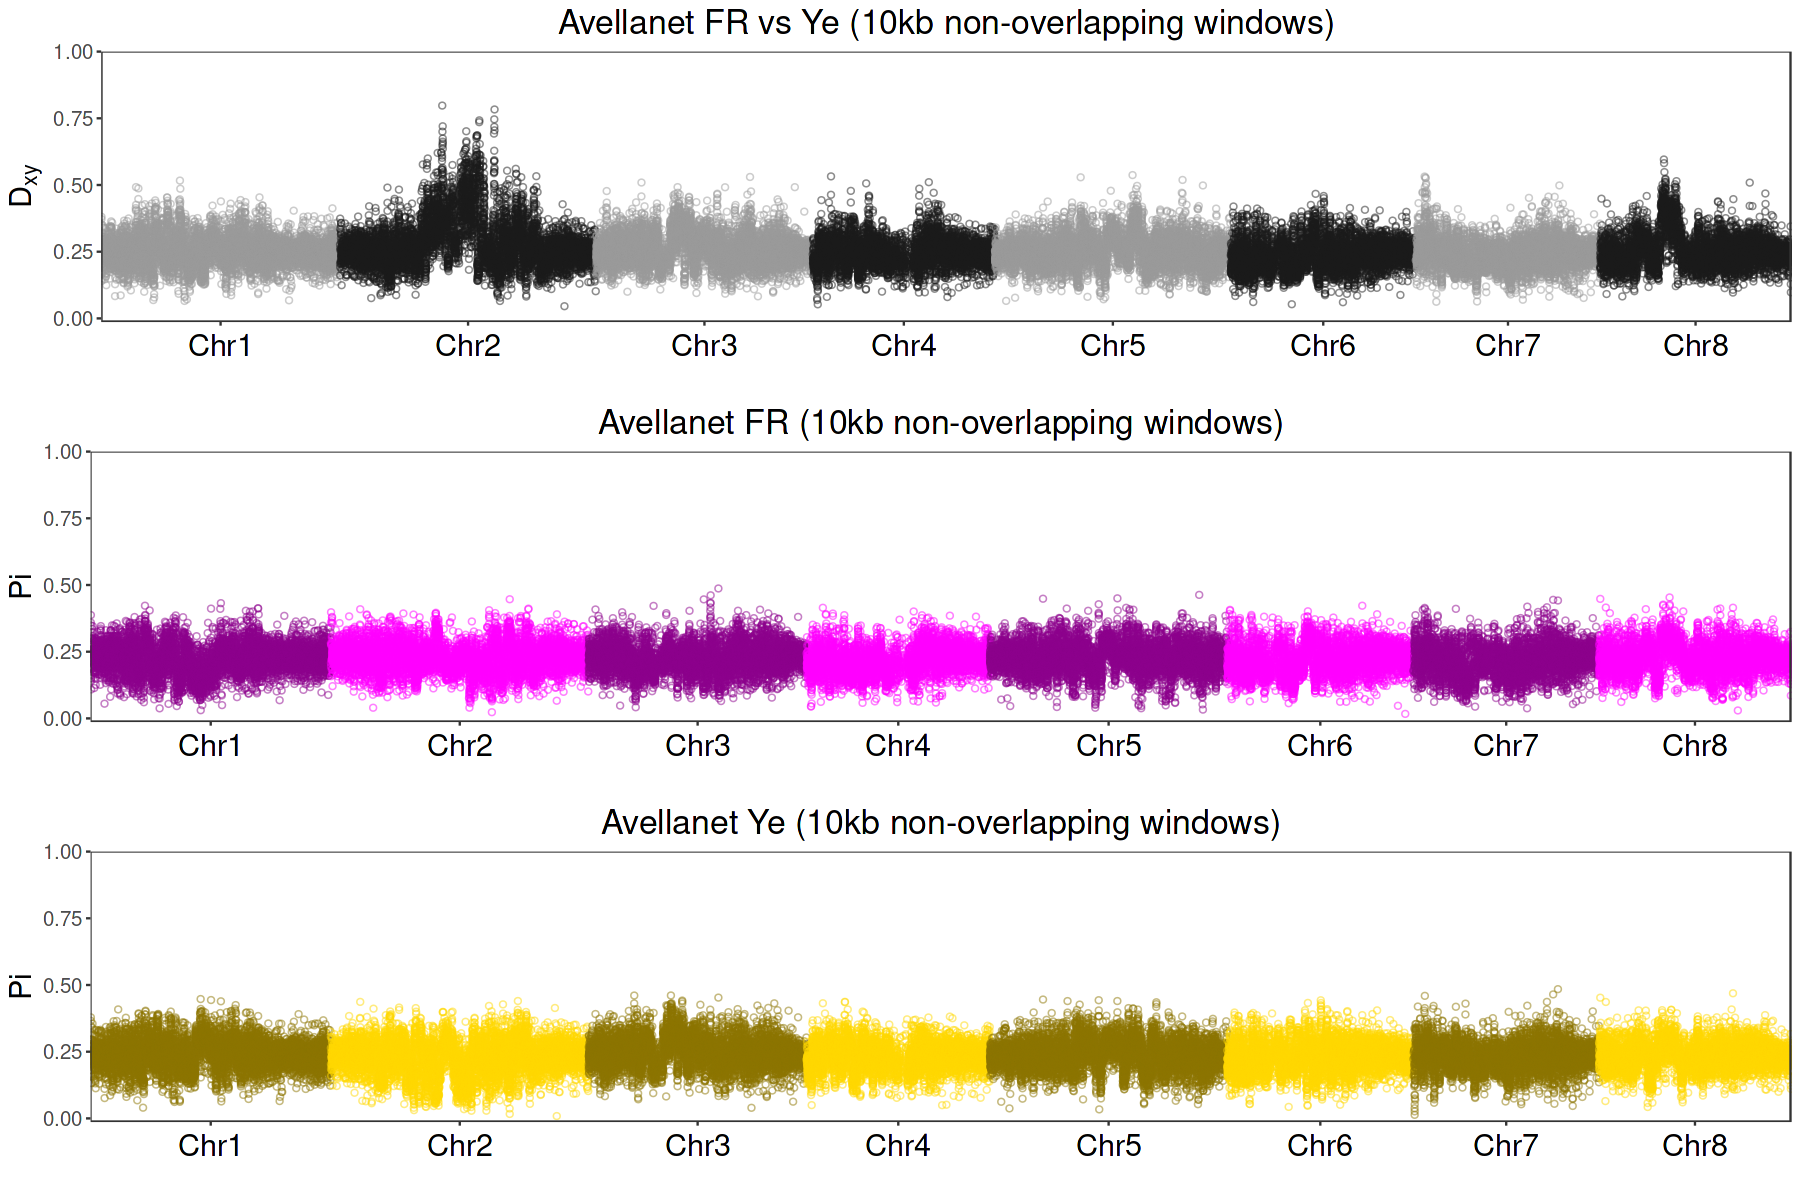

In [19]:
options(repr.plot.width=15, repr.plot.height=10)
plot_theme1 = plot_theme + 
                theme(legend.position = "none",
                      plot.title = element_text(hjust = 0.5, size=20), 
                      axis.title = element_text(size = 18),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
                      )


# Plots ----
dxy_AveFR_AveY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=dxy_AveFR_AveY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y=expression(D[xy]), title='Avellanet FR vs Ye (10kb non-overlapping windows)') +
    plot_theme1


pi_AveFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_AveFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("magenta4", "magenta"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y='Pi', title='Avellanet FR (10kb non-overlapping windows)') +
    plot_theme1


pi_AveY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_AveY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("gold4", "gold"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y='Pi', title='Avellanet Ye (10kb non-overlapping windows)') +
    plot_theme1


grid.arrange(dxy_AveFR_AveY, pi_AveFR, pi_AveY, nrow=3)

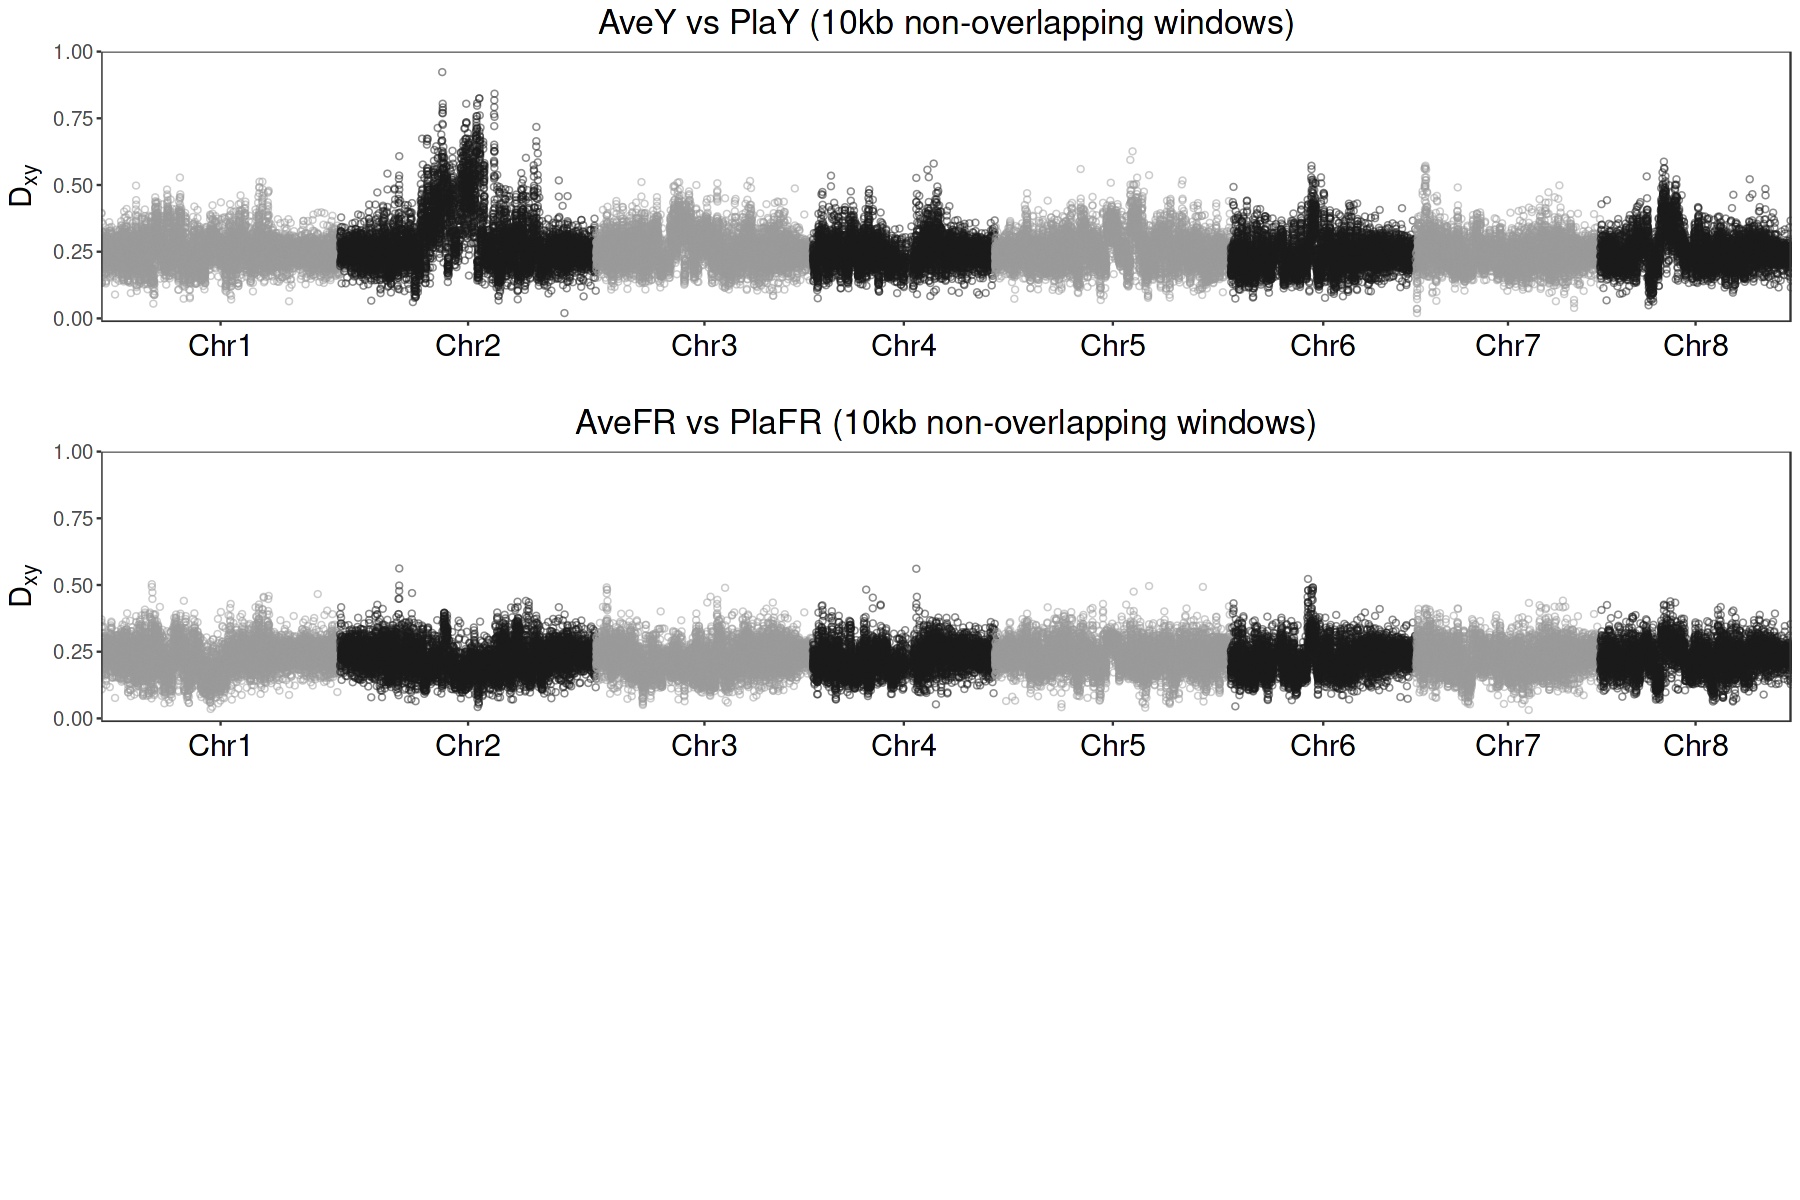

In [29]:
options(repr.plot.width=15, repr.plot.height=10)
plot_theme1 = plot_theme + 
                theme(legend.position = "none",
                      plot.title = element_text(hjust = 0.5, size=20), 
                      axis.title = element_text(size = 18),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
                      )


# Plots ----
dxy_AveY_PlaY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=dxy_AveY_PlaY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y=expression(D[xy]), title='AveY vs PlaY (10kb non-overlapping windows)') +
    plot_theme1

dxy_AveFR_PlaFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=dxy_AveFR_PlaFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.01,1)) +
    labs(x='', y=expression(D[xy]), title='AveFR vs PlaFR (10kb non-overlapping windows)') +
    plot_theme1

grid.arrange(dxy_AveY_PlaY, dxy_AveFR_PlaFR, nrow=3)

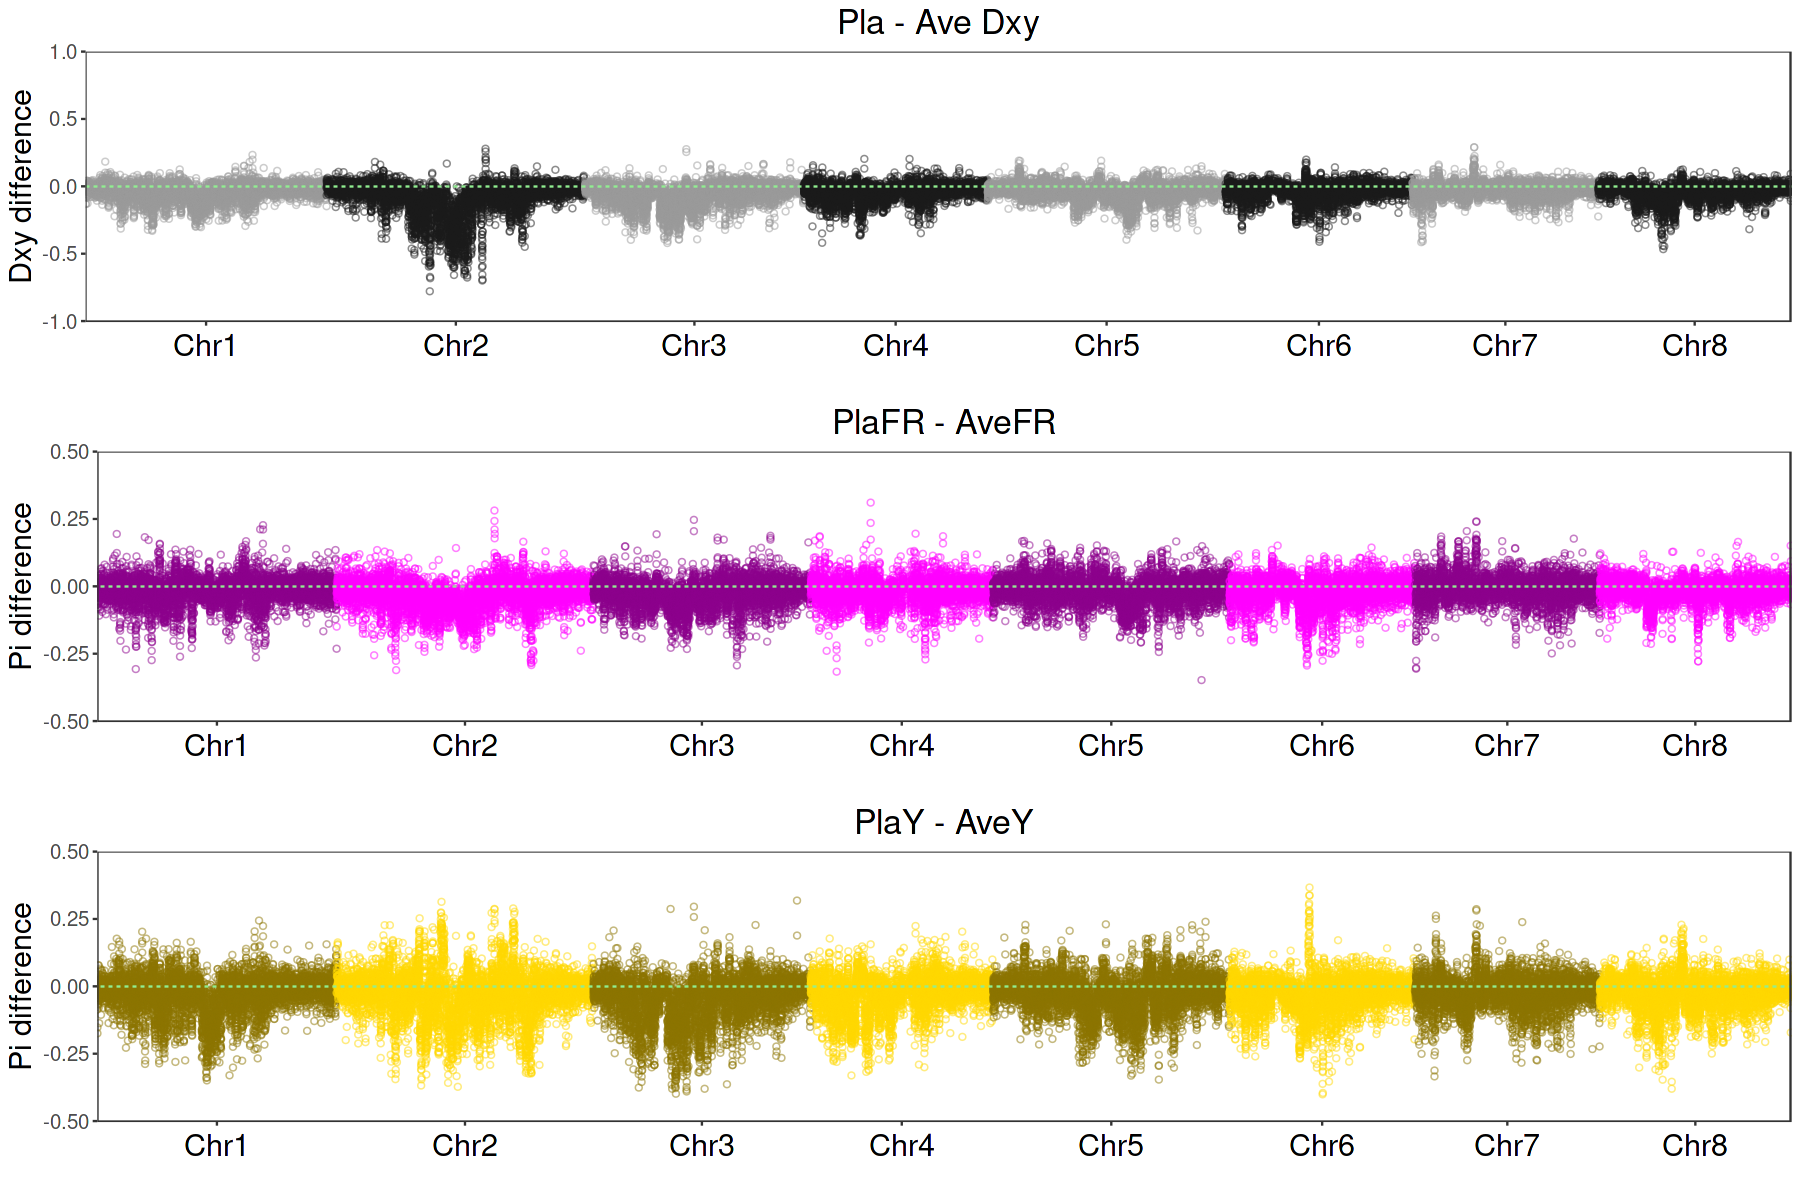

In [33]:
options(repr.plot.width=15, repr.plot.height=10)
plot_theme1 = plot_theme + 
                theme(legend.position = "none",
                      plot.title = element_text(hjust = 0.5, size=20), 
                      axis.title = element_text(size = 18),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 18, vjust = 0.2, color = 'black')
                      )


diff_dxy = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=dxy_PlaFR_PlaY-dxy_AveFR_AveY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    geom_abline(slope=0, intercept=0, col='lightgreen', lty=2) +
    scale_color_manual(values = rep(c("grey60", "grey10"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-1,1)) +
    labs(x='', y='Dxy difference', title='Pla - Ave Dxy') +
    plot_theme1

diff_piFR = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_PlaFR-pi_AveFR)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    geom_abline(slope=0, intercept=0, col='lightgreen', lty=2) +
    scale_color_manual(values = rep(c("magenta4", "magenta"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.5,0.5)) +
    labs(x='', y='Pi difference', title='PlaFR - AveFR') +
    plot_theme1

diff_piY = ggplot(AvePlaFRYe_w10KBs10KB[sites >= 10], aes(x=midCum, y=pi_PlaY-pi_AveY)) +
    geom_point(aes(color=as.factor(scaffold)), alpha=0.5, size=1.3, pch=1) +
    geom_abline(slope=0, intercept=0, col='lightgreen', lty=2) +
    scale_color_manual(values = rep(c("gold4", "gold"), 4)) +
    scale_x_continuous(expand = c(0, 0), label=axisToPlot$scaffold, breaks=axisToPlot$chromCenter) +
    scale_y_continuous(expand = c(0, 0), limits=c(-0.5,0.5)) +
    labs(x='', y='Pi difference', title='PlaY - AveY') +
    plot_theme1

grid.arrange(diff_dxy, diff_piFR, diff_piY, ncol=1)

### Dxy vs. Pi

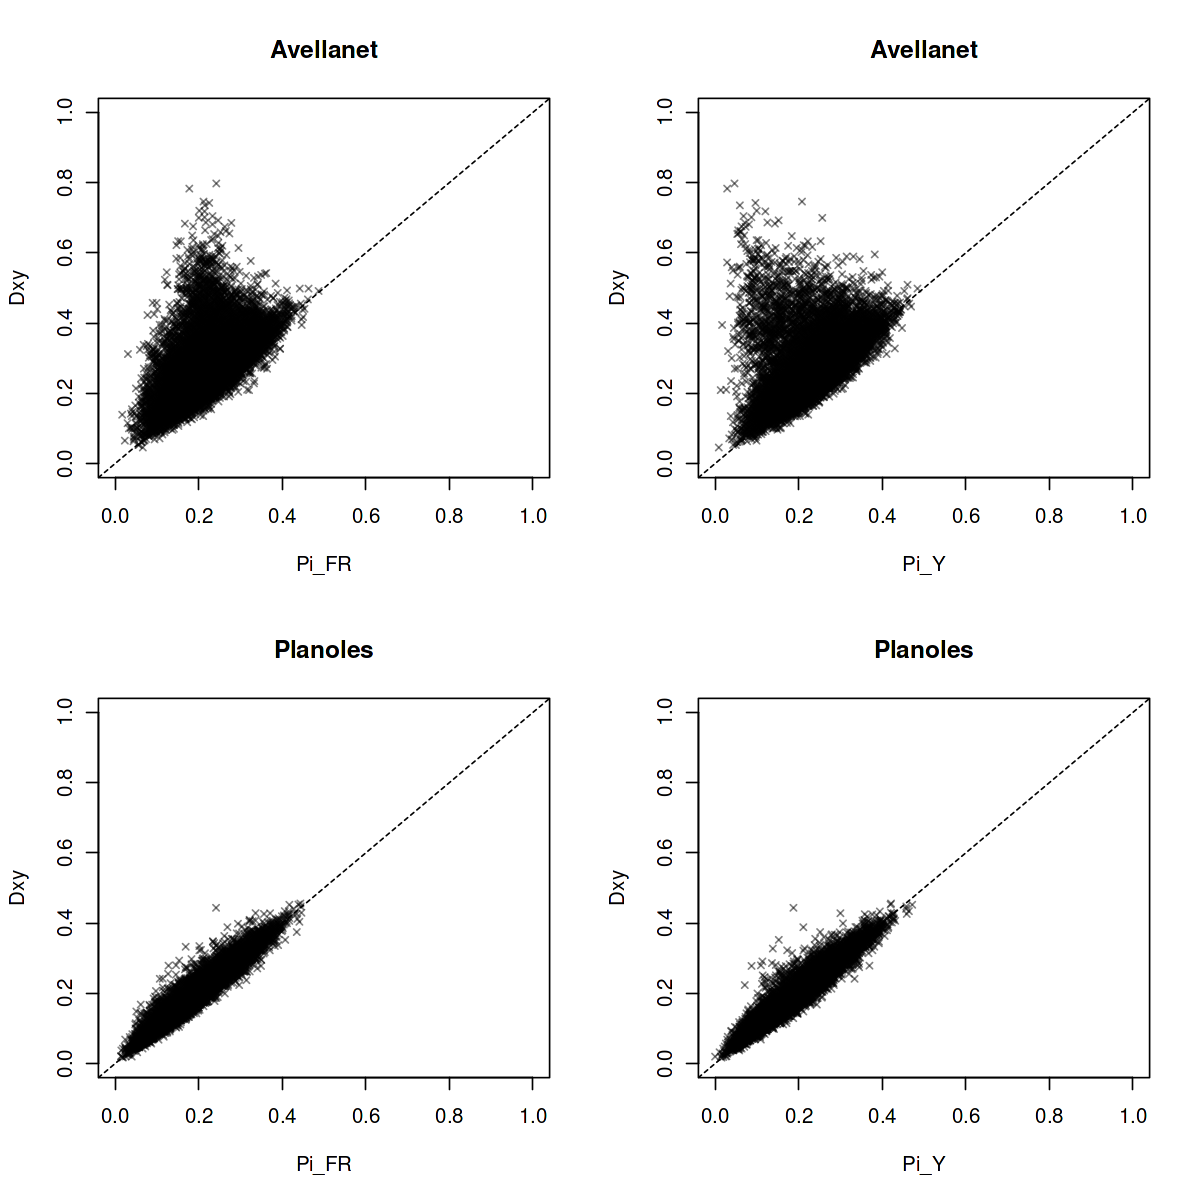

In [43]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(2,2), cex=1)
#1
plot(dxy_AveFR_AveY~pi_AveFR, AvePlaFRYe_w10KBs10KB[sites >= 10], 
     xlim=c(0,1), ylim=c(0,1), cex=0.7, pch=4, col=alpha('black', 0.5),
     main='Avellanet', xlab='Pi_FR', ylab='Dxy')
abline(a=0,b=1, lty=2)
plot(dxy_AveFR_AveY~pi_AveY, AvePlaFRYe_w10KBs10KB[sites >= 10], 
     xlim=c(0,1), ylim=c(0,1), cex=0.7, pch=4, col=alpha('black', 0.5),
     main='Avellanet', xlab='Pi_Y', ylab='Dxy')
abline(a=0,b=1, lty=2)

#2
plot(dxy_PlaFR_PlaY~pi_PlaFR, AvePlaFRYe_w10KBs10KB[sites >= 10], 
     xlim=c(0,1), ylim=c(0,1), cex=0.7, pch=4, col=alpha('black', 0.5),
     main='Planoles', xlab='Pi_FR', ylab='Dxy')
abline(a=0,b=1, lty=2)
plot(dxy_PlaFR_PlaY~pi_PlaY, AvePlaFRYe_w10KBs10KB[sites >= 10], 
     xlim=c(0,1), ylim=c(0,1), cex=0.7, pch=4, col=alpha('black', 0.5),
     main='Planoles', xlab='Pi_Y', ylab='Dxy')
abline(a=0,b=1, lty=2)